<a href="https://colab.research.google.com/github/khchoi-physik/pbh_simulations/blob/main/FEM_local.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# @title Import packages

import multiprocessing
import cupy as cp
import numpy as np

from cupyx.scipy.special import erf
import matplotlib.pyplot as plt

import time
import gc
import os

In [2]:
# @title 1.11 GPU Random field simulations

class GPU_RFSIM:

    def __init__(self, mean, std_dev, pixel, z_pixel, amplitude, k_power, lamb, n_sigma):
        self.mean = mean
        self.std_dev = std_dev
        self.pixel = pixel
        self.z_pixel = z_pixel
        self.amplitude = amplitude
        self.k_power = k_power
        self.lamb = lamb
        self.n_sigma = n_sigma

    def grf_64f(self):
        # 3D Fast Fourier transform of the white noise
        white_noise = cp.random.normal(self.mean, self.std_dev, (self.pixel, self.pixel, self.z_pixel))

        fft_white_noise = cp.fft.fftn(white_noise)
        del white_noise

        # Generating FFT momentum
        kx = cp.fft.fftfreq(self.pixel)*self.pixel
        ky = cp.fft.fftfreq(self.pixel)*self.pixel
        kz = cp.fft.fftfreq(self.z_pixel)*self.z_pixel

        kx_grid, ky_grid, kz_grid = cp.meshgrid(kx, ky, kz, sparse = True)
        del kx, ky, kz
        # Genearting FFT momentum 3D array
        # Norm of k

        k_norm = cp.sqrt(kx_grid**2 + ky_grid**2  + kz_grid**2)
        k_norm[0][0][0] = cp.inf  # Regularize divergence at k=0
        del kx_grid, ky_grid, kz_grid

        # Power Spectrum P_k
        power_spectrum = (self.amplitude*(((2*cp.pi/self.pixel)*k_norm)**(-1*self.k_power)))  # P(k)=amplitude/k^{power},
        del k_norm

        # Multiply the power spectrum with the transformed white noise to get the realization of the spectrum
        fourier_amplitudes_sqrt =  cp.sqrt(power_spectrum, out=power_spectrum)*fft_white_noise
        del power_spectrum, fft_white_noise

        # Perform inverse Fourier transform to obtain the Gaussian random field in the spatial domain
        gaussian_random_field = cp.fft.ifftn(fourier_amplitudes_sqrt).real
        del fourier_amplitudes_sqrt
        gc.collect()

        return gaussian_random_field

    def grf_64f_pk(self):
        # 3D Fast Fourier transform of the white noise
        white_noise = cp.random.normal(self.mean, self.std_dev, (self.pixel, self.pixel, self.z_pixel))

        fft_white_noise = cp.fft.fftn(white_noise)
        del white_noise

        # Generating FFT momentum
        kx = cp.fft.fftfreq(self.pixel)*self.pixel
        ky = cp.fft.fftfreq(self.pixel)*self.pixel
        kz = cp.fft.fftfreq(self.z_pixel)*self.z_pixel

        kx_grid, ky_grid, kz_grid = cp.meshgrid(kx, ky, kz, sparse = True)
        del kx, ky, kz
        # Genearting FFT momentum 3D array
        # Norm of k

        k_norm = cp.sqrt(kx_grid**2 + ky_grid**2  + kz_grid**2)
        ###k_norm[0][0][0] = cp.inf  # Regularize divergence at k=0
        del kx_grid, ky_grid, kz_grid

        # Power Spectrum P_k
        power_spectrum = (self.amplitude*(((2*cp.pi/self.pixel)*k_norm)**(-1*self.k_power)))  # P(k)=amplitude/k^{power},
        del k_norm

        # Multiply the power spectrum with the transformed white noise to get the realization of the spectrum
        fourier_amplitudes_sqrt =  cp.sqrt(power_spectrum, out=power_spectrum)*fft_white_noise
        del power_spectrum, fft_white_noise

        # Perform inverse Fourier transform to obtain the Gaussian random field in the spatial domain
        gaussian_random_field = cp.fft.ifftn(fourier_amplitudes_sqrt).real
        del fourier_amplitudes_sqrt
        gc.collect()

        return gaussian_random_field


    def gaussian_to_exp(self, grf):
        grf_mean = cp.mean(grf)
        grf_std_dev = cp.std(grf)
        xu = 0.5 * (1 + erf((grf - grf_mean) / (cp.sqrt(2) * grf_std_dev)))

        gc.collect()

        exprf = -1/self.lamb  * cp.log(1 - xu)

        return exprf
#        return gaussian_random_field

In [3]:
# @title Paramters

num_gpu = 1 #number of GPU



pixel = 2**9
z_pixel = pixel
n_sigma = 25
# 30 7.5 sigma
# 25 7
# 20 6
# 13 5
from google.colab import drive
drive.mount('/content/gdrive')

main_path = '/content/gdrive/MyDrive/2023 RFSimulations/simulated_results'
folder_path = main_path + '/correlation_length'

print(main_path)


Mounted at /content/gdrive
/content/gdrive/MyDrive/2023 RFSimulations/simulated_results


In [4]:
# # @title Run Multiprocessing Simulation

#     # Initialize an instance of RFSIM
# rfsim = GPU_RFSIM(mean=0, std_dev=1, pixel=pixel, z_pixel=z_pixel, amplitude=1.0, k_power=k_power, lamb=1.0, n_sigma=n_sigma+1)

#     # Generate a Gaussian random field
# grf = rfsim.grf_64f()  # grf can be _32f or _64f

#     ##grf = rfsim.grf_64f_pk()  # grf can be _32f or _64f
# exprf = rfsim.gaussian_to_exp(grf)
# del grf

In [43]:
# @title Run Multiprocessing Simulation

k_power = 3

# Initialize an instance of RFSIM
rfsim = GPU_RFSIM(mean=0, std_dev=1, pixel=pixel, z_pixel=z_pixel, amplitude=1.0, k_power=k_power, lamb=1.0, n_sigma=n_sigma+1)

while True:
        # Generate a Gaussian random field
    grf = rfsim.grf_64f()  # grf can be _32f or _64f

        ##grf = rfsim.grf_64f_pk()  # grf can be _32f or _64f
    exprf = rfsim.gaussian_to_exp(grf)
    del grf

    max_pos = cp.unravel_index(cp.argmax(exprf),(pixel,pixel,pixel))
    print(max_pos)

    std_exprf_box = []
    std_dx_exprf_box  = []
    std_dy_exprf_box  = []
    std_dz_exprf_box  = []
    absmean_dx_exprf_box  = []
    absmean_dy_exprf_box  = []
    absmean_dz_exprf_box  = []
    corr_x = []
    corr_y = []
    corr_z = []

    max_length = 64

    Mxmin = max_pos[0] -max_length
    Mymin = max_pos[1] -max_length
    Mzmin = max_pos[2] -max_length

    Mxmax = max_pos[0] +max_length +1
    Mymax = max_pos[1] +max_length +1
    Mzmax = max_pos[2] +max_length +1


    if Mxmax < pixel and Mymax < pixel and Mzmax < pixel and \
    Mxmin > 0 and Mymin > 0 and Mzmin > 0 :

        for length in range(max_length):

            xmin = max_pos[0] -length
            xmax = max_pos[0] +length +1
            ymin = max_pos[1] -length
            ymax = max_pos[1] +length +1
            zmin = max_pos[2] -length
            zmax = max_pos[2] +length +1

            sub_exprf = exprf[xmin:xmax,ymin:ymax,zmin:zmax]
            cdx_max_exprf = (exprf[xmin-2 : xmax,:,: ] - exprf[xmin: xmax+2, : , :])/2
            cdy_max_exprf = (exprf[:, ymin-2 : ymax ,: ] - exprf[:, ymin: ymax+2 , :])/2
            cdz_max_exprf = (exprf[:,:,zmin-2 : zmax ] - exprf[:, : , zmin: zmax+2])/2

            std_box = cp.asnumpy(cp.std( sub_exprf ))
            dx_std_box = cp.asnumpy(cp.std(  cdx_max_exprf) )
            dy_std_box = cp.asnumpy(cp.std(  cdy_max_exprf) )
            dz_std_box = cp.asnumpy(cp.std(  cdz_max_exprf) )

            dx_absmean_box = cp.asnumpy(cp.mean(  cp.abs(cdx_max_exprf) ) )
            dy_absmean_box = cp.asnumpy(cp.mean(  cp.abs(cdy_max_exprf) ) )
            dz_absmean_box = cp.asnumpy(cp.mean(  cp.abs(cdz_max_exprf) ) )

            std_exprf_box.append(std_box)
            std_dx_exprf_box.append(dx_std_box)
            std_dy_exprf_box.append(dy_std_box)
            std_dz_exprf_box.append(dz_std_box)
            absmean_dx_exprf_box.append(dx_absmean_box)
            absmean_dy_exprf_box.append(dy_absmean_box)
            absmean_dz_exprf_box.append(dz_absmean_box)
            corr_x.append(std_box/dx_std_box)
            corr_y.append(std_box/dy_std_box)
            corr_z.append(std_box/dz_std_box)

        break

    else:
        print('Condition violated')

(array(362), array(485), array(405))
Condition violated
(array(122), array(441), array(141))


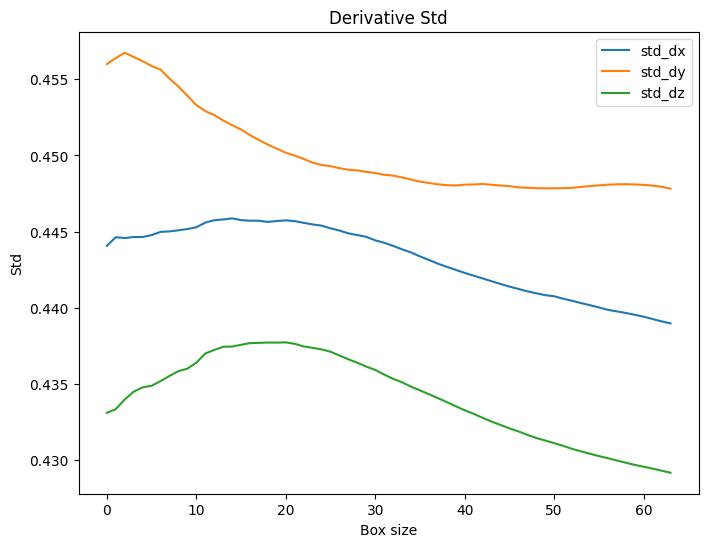

In [44]:


save_folder = folder_path
os.chdir(save_folder)

plt.figure( figsize=(8,6))

plt.plot(np.arange(max_length),std_dx_exprf_box, label = 'std_dx' )
plt.plot(np.arange(max_length),std_dy_exprf_box, label = 'std_dy' )
plt.plot(np.arange(max_length),std_dz_exprf_box, label = 'std_dz' )
# plt.plot(np.arange(max_length),std_exprf_box, label = 'std' )
# plt.plot(np.arange(max_length),corr, label = 'corr')
plt.legend()
plt.title('Derivative Std')
plt.ylabel('Std')
plt.xlabel('Box size')

plt.savefig(f'derivative_std_k_{k_power}_max_l_{max_length}.pdf', bbox_inches=None,)

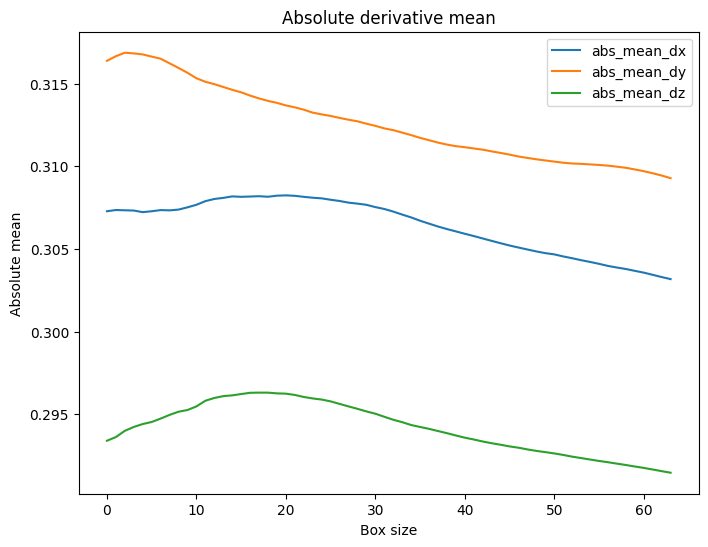

In [45]:
plt.figure( figsize=(8,6))

plt.plot(np.arange(max_length),absmean_dx_exprf_box, label = 'abs_mean_dx' )
plt.plot(np.arange(max_length),absmean_dy_exprf_box, label = 'abs_mean_dy' )
plt.plot(np.arange(max_length),absmean_dz_exprf_box, label = 'abs_mean_dz' )

plt.legend()
plt.title('Absolute derivative mean')
plt.ylabel('Absolute mean')
plt.xlabel('Box size')

plt.savefig(f'absmean_k_{k_power}_max_l_{max_length}.pdf', bbox_inches=None)

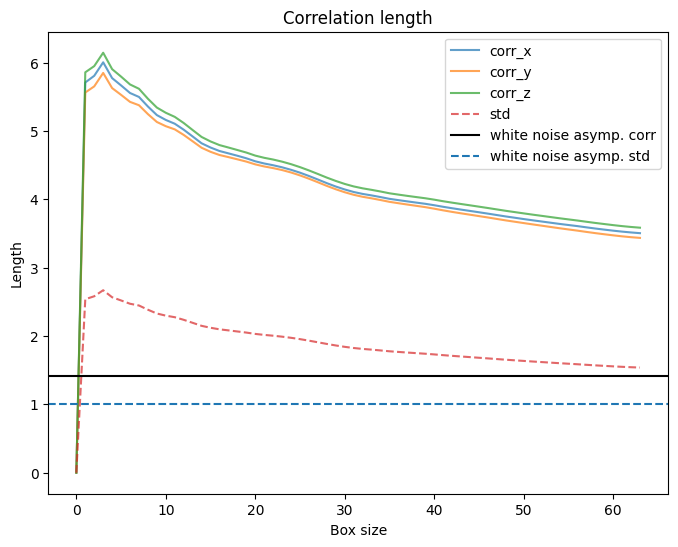

In [46]:
plt.figure( figsize=(8,6))

plt.plot(np.arange(max_length),corr_x, label = 'corr_x' , alpha=0.7 )
plt.plot(np.arange(max_length),corr_y, label = 'corr_y' , alpha=0.7 )
plt.plot(np.arange(max_length),corr_z, label = 'corr_z' , alpha=0.7 )
plt.plot(np.arange(max_length), std_exprf_box, linestyle = '--', label = 'std', alpha=0.7  )
plt.axhline(2/np.sqrt(2), c='black', label ='white noise asymp. corr')
plt.axhline(1, linestyle = '--',label ='white noise asymp. std')
# plt.plot(np.arange(max_length),std_exprf_box, label = 'std' )
# plt.plot(np.arange(max_length),corr, label = 'corr')
plt.legend()
plt.title('Correlation length')
plt.ylabel('Length')
plt.xlabel('Box size')
plt.savefig(f'corr_k_{k_power}_max_l_{max_length}.pdf', bbox_inches=None)

In [34]:
np.mean(corr_z[20])

1.5382358551907698

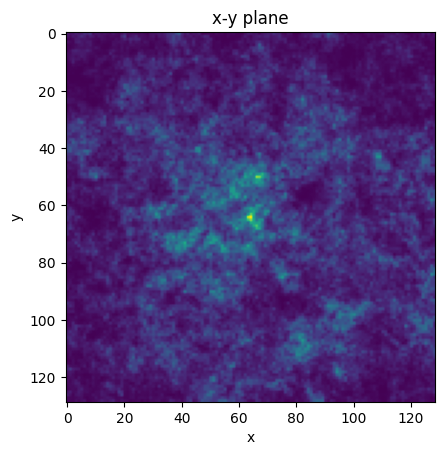

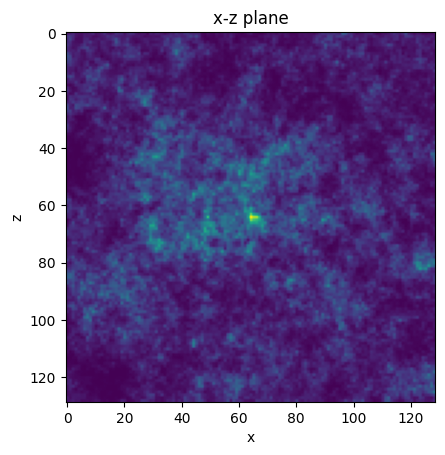

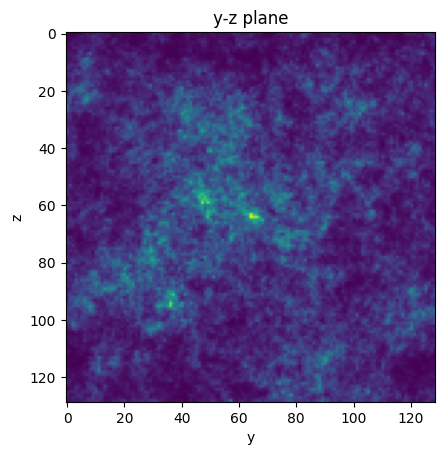

In [10]:
plt.imshow( cp.asnumpy(exprf[Mxmin:Mxmax,Mymin:Mymax, max_pos[2] ]) )
plt.title('x-y plane')
plt.xlabel('x')
plt.ylabel('y')
plt.show()
plt.imshow( cp.asnumpy(exprf[Mxmin:Mxmax,max_pos[1], Mzmin:Mzmax ]) )
plt.title('x-z plane')
plt.xlabel('x')
plt.ylabel('z')
plt.show()
plt.imshow( cp.asnumpy(exprf[max_pos[0],Mymin:Mymax,  Mzmin:Mzmax]) )
plt.title('y-z plane')
plt.xlabel('y')
plt.ylabel('z')
plt.show()

In [ ]:
# # @title Forward differences

# fdx_exprf = exprf[1:, :, :] - exprf[:-1, :, :]
# fdy_exprf = exprf[:, 1:, :] - exprf[:, :-1, :]
# fdz_exprf = exprf[:, :, 1:] - exprf[:, :, :-1]

# print('shape =', fdx_exprf.shape, '\ndiff_sigma = ', cp.std(fdx_exprf), '\nco_length =', cp.std(exprf)/cp.std(fdx_exprf))

# # @title Backward differences

# bdx_exprf = exprf[1:, :, :] - exprf[:-1, :, :]
# bdy_exprf = exprf[:, 1:, :] - exprf[:, :-1, :]
# bdz_exprf = exprf[:, :, 1:] - exprf[:, :, :-1]

# print('shape =', bdx_exprf.shape, '\ndiff_sigma = ', cp.std(bdx_exprf), '\nco_length =', cp.std(exprf)/cp.std(bdx_exprf))

# # @title Central differences

# cdx_exprf = (exprf[2:, :, :] - exprf[:-2, :, :]) / 2
# cdy_exprf = (exprf[:, 2:, :] - exprf[:, :-2, :]) / 2
# cdz_exprf = (exprf[:, :, 2:] - exprf[:, :, :-2]) / 2

# print('shape =', cdx_exprf.shape, '\ndiff_sigma = ', cp.std(cdx_exprf), '\nco_length =', cp.std(exprf)/cp.std(cdx_exprf))

# cdx2 = (fdx_exprf[1:, :, :] + bdx_exprf[:-1, :, :]) / 2
# cdy2 = (fdy_exprf[:, 1:, :] + bdy_exprf[:, :-1, :]) / 2
# cdz2 = (fdz_exprf[:, :, 1:] + bdz_exprf[:, :, :-1]) / 2

# print('shape =', cdx2.shape, '\ndiff_sigma = ', cp.std(cdx2), '\nco_length =', cp.std(exprf)/cp.std(cdx2))